In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("=" * 90)
print("ANOMALY DETECTION FOR PRICING FRAUD - SECOND-HAND CAR SALES")
print("=" * 90)

print("\n[STEP 1] LOADING AND EXPLORING DATASET")
print("-" * 90)

df = pd.read_csv('F:\MCA\Datascience\car_sales_data.csv')  

print(f"\nDataset Shape: {df.shape}")
print(f"Total Records: {len(df)}")
print(f"Total Features: {len(df.columns)}\n")

print("Dataset Info:")
print(df.info())

print("\nFirst Few Rows:")
print(df.head(10))

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\nData Types:")
print(df.dtypes)

categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nCategorical Columns: {list(categorical_cols)}")

ANOMALY DETECTION FOR PRICING FRAUD - SECOND-HAND CAR SALES

[STEP 1] LOADING AND EXPLORING DATASET
------------------------------------------------------------------------------------------

Dataset Shape: (50000, 7)
Total Records: 50000
Total Features: 7

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB
None

First Few Rows:
  Manufacturer       Model  Engine size Fuel type  Year of manufacture  \
0         Fo

In [ ]:
print("\n[STEP 2] DATA PREPROCESSING & FEATURE ENGINEERING")
print("-" * 90)

df_processed = df.copy()


print("\nHandling Missing Values...")
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].median())

categorical_cols_list = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols_list:
    df_processed[col].fillna(df_processed[col].mode()[0] if len(df_processed[col].mode()) > 0 else 'Unknown', inplace=True)

print(f"Missing values after imputation: {df_processed.isnull().sum().sum()}")

initial_rows = len(df_processed)
df_processed.drop_duplicates(inplace=True)
print(f"Rows after removing duplicates: {initial_rows} → {len(df_processed)}")

price_Q1 = df_processed['Price'].quantile(0.01)
price_Q3 = df_processed['Price'].quantile(0.99)
df_processed = df_processed[(df_processed['Price'] >= price_Q1) & 
                            (df_processed['Price'] <= price_Q3)]
print(f"Rows after removing extreme price outliers: {len(df_processed)}")

print("\nEncoding Categorical Variables...")
label_encoders = {}
categorical_features = ['Manufacturer', 'Fuel type']

for col in categorical_features:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{col}_Encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"  {col}: {df_processed[col].nunique()} unique values encoded")

print("\nCreating Engineered Features...")
df_processed['Car_Age'] = 2025 - df_processed['Year of manufacture']
df_processed['Price_per_CC'] = df_processed['Price'] / (df_processed['Engine size'] + 1)
df_processed['Price_per_Mileage'] = df_processed['Price'] / (df_processed['Mileage'] + 1)
df_processed['Mileage_per_Year'] = df_processed['Mileage'] / (df_processed['Car_Age'] + 1)
df_processed['Engine_Mileage_Ratio'] = df_processed['Engine size'] / (df_processed['Mileage'] + 1)
df_processed['Price_Age_Ratio'] = df_processed['Price'] / (df_processed['Car_Age'] + 1)

print("  ✓ Car_Age: Vehicle age in years")
print("  ✓ Price_per_CC: Price normalized by engine displacement")
print("  ✓ Price_per_Mileage: Price per unit mileage")
print("  ✓ Mileage_per_Year: Average annual mileage")
print("  ✓ Engine_Mileage_Ratio: Engine size to mileage relationship")
print("  ✓ Price_Age_Ratio: Price depreciation rate")


[STEP 2] DATA PREPROCESSING & FEATURE ENGINEERING
------------------------------------------------------------------------------------------

Handling Missing Values...
Missing values after imputation: 0
Rows after removing duplicates: 50000 → 49988
Rows after removing extreme price outliers: 48988

Encoding Categorical Variables...
  Manufacturer: 5 unique values encoded
  Fuel type: 3 unique values encoded

Creating Engineered Features...
  ✓ Car_Age: Vehicle age in years
  ✓ Price_per_CC: Price normalized by engine displacement
  ✓ Price_per_Mileage: Price per unit mileage
  ✓ Mileage_per_Year: Average annual mileage
  ✓ Engine_Mileage_Ratio: Engine size to mileage relationship
  ✓ Price_Age_Ratio: Price depreciation rate


In [ ]:
print("\n[STEP 3] FEATURE SELECTION FOR ANOMALY DETECTION")
print("-" * 90)

feature_columns = ['Engine size', 'Year of manufacture', 'Mileage', 'Price',
                   'Manufacturer_Encoded', 'Fuel type_Encoded', 'Car_Age',
                   'Price_per_CC', 'Price_per_Mileage', 'Mileage_per_Year',
                   'Engine_Mileage_Ratio', 'Price_Age_Ratio']

feature_columns = [col for col in feature_columns if col in df_processed.columns]

X = df_processed[feature_columns].copy()

print(f"Features selected: {len(feature_columns)}")
print(f"Features: {feature_columns}\n")
print(f"Feature Data Shape: {X.shape}")


[STEP 3] FEATURE SELECTION FOR ANOMALY DETECTION
------------------------------------------------------------------------------------------
Features selected: 12
Features: ['Engine size', 'Year of manufacture', 'Mileage', 'Price', 'Manufacturer_Encoded', 'Fuel type_Encoded', 'Car_Age', 'Price_per_CC', 'Price_per_Mileage', 'Mileage_per_Year', 'Engine_Mileage_Ratio', 'Price_Age_Ratio']

Feature Data Shape: (48988, 12)


In [4]:
print("\n[STEP 4] STANDARDIZATION OF FEATURES")
print("-" * 90)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

print("Features standardized using StandardScaler")
print(f"Scaled Data Shape: {X_scaled.shape}")
print(f"\nScaled Data Statistics:")
print(X_scaled_df.describe())


[STEP 4] STANDARDIZATION OF FEATURES
------------------------------------------------------------------------------------------
Features standardized using StandardScaler
Scaled Data Shape: (48988, 12)

Scaled Data Statistics:
        Engine size  Year of manufacture       Mileage         Price  \
count  4.898800e+04         4.898800e+04  4.898800e+04  4.898800e+04   
mean   1.911683e-16        -2.641691e-15  1.595487e-17 -6.294920e-17   
std    1.000010e+00         1.000010e+00  1.000010e+00  1.000010e+00   
min   -1.076060e+00        -2.132948e+00 -1.614012e+00 -9.331517e-01   
25%   -5.062078e-01        -8.678069e-01 -8.169445e-01 -7.336076e-01   
50%   -2.212818e-01        -2.437931e-02 -1.501406e-01 -3.747985e-01   
75%    3.485702e-01         8.190483e-01  6.699788e-01  4.187686e-01   
max    4.622461e+00         1.873333e+00  4.719316e+00  4.874654e+00   

       Manufacturer_Encoded  Fuel type_Encoded       Car_Age  Price_per_CC  \
count          4.898800e+04       4.898800e+0

In [ ]:
print("\n[STEP 5] APPLYING ANOMALY DETECTION ALGORITHMS")
print("-" * 90)

anomaly_results = pd.DataFrame(index=df_processed.index)
anomaly_results['Original_Price'] = df_processed['Price'].values

print("\n[Algorithm 1] ISOLATION FOREST")
print("  Parameters: contamination=0.05 (expect 5% anomalies)")
print("  Theory: Isolates anomalies by randomly selecting features/split values")

iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1, n_estimators=100)
anomaly_results['Isolation_Forest'] = iso_forest.fit_predict(X_scaled)
iso_scores = iso_forest.score_samples(X_scaled)
anomaly_results['IF_Anomaly_Score'] = iso_scores
anomaly_results['IF_Anomaly_Probability'] = 1 / (1 + np.exp(iso_scores))

iso_anomalies = (anomaly_results['Isolation_Forest'] == -1).sum()
print(f"  ✓ Anomalies Detected: {iso_anomalies} ({iso_anomalies/len(anomaly_results)*100:.2f}%)")

print("\n[Algorithm 2] LOCAL OUTLIER FACTOR (LOF)")
print("  Parameters: n_neighbors=20, contamination=0.05")
print("  Theory: Detects outliers based on local density deviation from neighbors")

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, n_jobs=-1)
anomaly_results['LOF'] = lof.fit_predict(X_scaled)
lof_scores = lof.negative_outlier_factor_
anomaly_results['LOF_Score'] = lof_scores
anomaly_results['LOF_Anomaly_Probability'] = 1 / (1 + np.exp(lof_scores))

lof_anomalies = (anomaly_results['LOF'] == -1).sum()
print(f"  ✓ Anomalies Detected: {lof_anomalies} ({lof_anomalies/len(anomaly_results)*100:.2f}%)")

print("\n[Algorithm 3] ELLIPTIC ENVELOPE (Robust Covariance)")
print("  Parameters: contamination=0.05")
print("  Theory: Assumes normal data fits within ellipsoid; detects outliers outside")

elliptic = EllipticEnvelope(contamination=0.05, random_state=42)
anomaly_results['Elliptic_Envelope'] = elliptic.fit_predict(X_scaled)
elliptic_scores = elliptic.score_samples(X_scaled)
anomaly_results['EE_Anomaly_Score'] = elliptic_scores
anomaly_results['EE_Anomaly_Probability'] = 1 / (1 + np.exp(elliptic_scores))

ee_anomalies = (anomaly_results['Elliptic_Envelope'] == -1).sum()
print(f"  ✓ Anomalies Detected: {ee_anomalies} ({ee_anomalies/len(anomaly_results)*100:.2f}%)")

print("\n[Algorithm 4] DBSCAN (Density-Based Clustering)")
print("  Parameters: eps=2.5, min_samples=5")
print("  Theory: Groups closely packed points; marks isolated points as anomalies")

dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
anomaly_results['DBSCAN'] = np.where(dbscan_labels == -1, -1, 1)

dbscan_anomalies = (anomaly_results['DBSCAN'] == -1).sum()
print(f"  ✓ Anomalies Detected: {dbscan_anomalies} ({dbscan_anomalies/len(anomaly_results)*100:.2f}%)")

print("\n[Algorithm 5] Z-SCORE BASED DETECTION")
print("  Parameters: threshold=3 (standard deviations from mean)")
print("  Theory: Flags values that deviate significantly from mean")

z_scores = np.abs(zscore(X_scaled))
z_anomalies = (z_scores > 3).any(axis=1)
anomaly_results['Z_Score'] = np.where(z_anomalies, -1, 1)
anomaly_results['Z_Score_Max'] = z_scores.max(axis=1)

z_score_anomalies = (anomaly_results['Z_Score'] == -1).sum()
print(f"  ✓ Anomalies Detected: {z_score_anomalies} ({z_score_anomalies/len(anomaly_results)*100:.2f}%)")

print("\n[Algorithm 6] ENSEMBLE VOTING")
print("  Theory: Combines predictions from all methods for high-confidence detection")

anomaly_results['Ensemble_Votes'] = (
    (anomaly_results['Isolation_Forest'] == -1).astype(int) +
    (anomaly_results['LOF'] == -1).astype(int) +
    (anomaly_results['Elliptic_Envelope'] == -1).astype(int) +
    (anomaly_results['DBSCAN'] == -1).astype(int) +
    (anomaly_results['Z_Score'] == -1).astype(int)
)

anomaly_results['Ensemble_Prediction_Strict'] = (
    anomaly_results['Ensemble_Votes'] >= 3
).astype(int) * (-1)

anomaly_results['Ensemble_Prediction_Medium'] = (
    anomaly_results['Ensemble_Votes'] >= 2
).astype(int) * (-1)

ensemble_anomalies_strict = (anomaly_results['Ensemble_Prediction_Strict'] == -1).sum()
ensemble_anomalies_medium = (anomaly_results['Ensemble_Prediction_Medium'] == -1).sum()

print(f"  ✓ High-Confidence Anomalies (3+ votes): {ensemble_anomalies_strict} ({ensemble_anomalies_strict/len(anomaly_results)*100:.2f}%)")
print(f"  ✓ Medium-Confidence Anomalies (2+ votes): {ensemble_anomalies_medium} ({ensemble_anomalies_medium/len(anomaly_results)*100:.2f}%)")


[STEP 5] APPLYING ANOMALY DETECTION ALGORITHMS
------------------------------------------------------------------------------------------

[Algorithm 1] ISOLATION FOREST
  Parameters: contamination=0.05 (expect 5% anomalies)
  Theory: Isolates anomalies by randomly selecting features/split values
  ✓ Anomalies Detected: 2450 (5.00%)

[Algorithm 2] LOCAL OUTLIER FACTOR (LOF)
  Parameters: n_neighbors=20, contamination=0.05
  Theory: Detects outliers based on local density deviation from neighbors
  ✓ Anomalies Detected: 2450 (5.00%)

[Algorithm 3] ELLIPTIC ENVELOPE (Robust Covariance)
  Parameters: contamination=0.05
  Theory: Assumes normal data fits within ellipsoid; detects outliers outside
  ✓ Anomalies Detected: 2450 (5.00%)

[Algorithm 4] DBSCAN (Density-Based Clustering)
  Parameters: eps=2.5, min_samples=5
  Theory: Groups closely packed points; marks isolated points as anomalies
  ✓ Anomalies Detected: 57 (0.12%)

[Algorithm 5] Z-SCORE BASED DETECTION
  Parameters: threshold=3

In [ ]:
print("\n[STEP 6] CLASSIFYING OVERPRICED VS UNDERPRICED VEHICLES")
print("-" * 90)

def classify_price_anomaly(row, group_data):
    """Classify if vehicle is overpriced or underpriced"""
    manufacturer = row['Manufacturer']
    car_age = row['Car_Age']
    actual_price = row['Price']
    
    similar = group_data[
        (group_data['Manufacturer'] == manufacturer) &
        (abs(group_data['Car_Age'] - car_age) <= 2)
    ]
    
    if len(similar) > 5:
        expected_price = similar['Price'].median()
        price_deviation = (actual_price - expected_price) / expected_price * 100
        
        if actual_price > expected_price * 1.15:
            return 'OVERPRICED', price_deviation
        elif actual_price < expected_price * 0.85:
            return 'UNDERPRICED', price_deviation
    
    return 'NORMAL', 0

print("Classifying anomalies by price...")
classification_results = df_processed.apply(
    lambda row: classify_price_anomaly(row, df_processed),
    axis=1
)

anomaly_results['Price_Classification'] = classification_results.apply(lambda x: x[0])
anomaly_results['Price_Deviation_Percent'] = classification_results.apply(lambda x: x[1])

print("\nPrice Classification Distribution:")
print(anomaly_results['Price_Classification'].value_counts())

print("\nPrice Deviation Statistics:")
print(f"  Mean Deviation: {anomaly_results['Price_Deviation_Percent'].mean():.2f}%")
print(f"  Max Overpriced: {anomaly_results['Price_Deviation_Percent'].max():.2f}%")
print(f"  Max Underpriced: {anomaly_results['Price_Deviation_Percent'].min():.2f}%")


[STEP 6] CLASSIFYING OVERPRICED VS UNDERPRICED VEHICLES
------------------------------------------------------------------------------------------
Classifying anomalies by price...

Price Classification Distribution:
Price_Classification
OVERPRICED     18152
UNDERPRICED    17342
NORMAL         13494
Name: count, dtype: int64

Price Deviation Statistics:
  Mean Deviation: 8.72%
  Max Overpriced: 464.15%
  Max Underpriced: -87.19%


In [ ]:
print("\n[STEP 7] DETAILED ANOMALY DETECTION RESULTS")
print("-" * 90)

high_confidence_anomalies = anomaly_results[
    anomaly_results['Ensemble_Prediction_Strict'] == -1
].copy()

medium_confidence_anomalies = anomaly_results[
    anomaly_results['Ensemble_Prediction_Medium'] == -1
].copy()

high_confidence_detail = high_confidence_anomalies.join(
    df_processed[['Manufacturer', 'Model', 'Engine size', 'Fuel type',
                  'Year of manufacture', 'Mileage', 'Car_Age']]
)

medium_confidence_detail = medium_confidence_anomalies.join(
    df_processed[['Manufacturer', 'Model', 'Engine size', 'Fuel type',
                  'Year of manufacture', 'Mileage', 'Car_Age']]
)

print(f"\nHigh-Confidence Anomalies (3+ method agreement): {len(high_confidence_anomalies)}")
print(f"Medium-Confidence Anomalies (2+ method agreement): {len(medium_confidence_anomalies)}")

print("\n" + "=" * 90)
print("TOP 15 HIGH-CONFIDENCE ANOMALOUS VEHICLES:")
print("=" * 90)

if len(high_confidence_detail) > 0:
    top_anomalies = high_confidence_detail.nlargest(min(15, len(high_confidence_detail)), 'Ensemble_Votes')
    
    for idx, (i, row) in enumerate(top_anomalies.iterrows(), 1):
        avg_anomaly_prob = (row['IF_Anomaly_Probability'] + row['LOF_Anomaly_Probability'] + 
                           row['EE_Anomaly_Probability']) / 3
        
        print(f"\n[{idx}] {row['Manufacturer']} {row['Model']}")
        print(f"     Year: {int(row['Year of manufacture'])}, Age: {int(row['Car_Age'])} years")
        print(f"     Mileage: {row['Mileage']:.0f} miles, Engine: {row['Engine size']:.1f}cc")
        print(f"     Fuel Type: {row['Fuel type']}")
        print(f"     Price: ${row['Original_Price']:,.2f}")
        print(f"     Classification: {row['Price_Classification']} ({row['Price_Deviation_Percent']:+.2f}%)")
        print(f"     Detection Consensus: {int(row['Ensemble_Votes'])}/5 methods")
        print(f"     Avg Anomaly Probability: {avg_anomaly_prob:.3f}")
else:
    print("No high-confidence anomalies detected.")


[STEP 7] DETAILED ANOMALY DETECTION RESULTS
------------------------------------------------------------------------------------------

High-Confidence Anomalies (3+ method agreement): 1479
Medium-Confidence Anomalies (2+ method agreement): 2684

TOP 15 HIGH-CONFIDENCE ANOMALOUS VEHICLES:

[1] Ford Mondeo
     Year: 2022, Age: 3 years
     Mileage: 1487 miles, Engine: 2.0cc
     Fuel Type: Diesel
     Price: $56,459.00
     Classification: OVERPRICED (+43.08%)
     Detection Consensus: 5/5 methods
     Avg Anomaly Probability: 0.842

[2] Porsche 718 Cayman
     Year: 2022, Age: 3 years
     Mileage: 4624 miles, Engine: 2.4cc
     Fuel Type: Petrol
     Price: $78,086.00
     Classification: OVERPRICED (+20.75%)
     Detection Consensus: 5/5 methods
     Avg Anomaly Probability: 0.816

[3] Porsche Cayenne
     Year: 2013, Age: 12 years
     Mileage: 5000 miles, Engine: 4.0cc
     Fuel Type: Petrol
     Price: $65,380.00
     Classification: OVERPRICED (+43.74%)
     Detection Consensus

In [8]:
print("\n[STEP 8] PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("-" * 90)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained Variance Ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")

anomaly_results['PCA1'] = X_pca[:, 0]
anomaly_results['PCA2'] = X_pca[:, 1]

print(f"\nTop Contributing Features to PC1:")
pc1_contrib = pd.DataFrame({
    'Feature': feature_columns,
    'PC1_Loading': pca.components_[0]
}).sort_values('PC1_Loading', key=abs, ascending=False)
print(pc1_contrib.head())


[STEP 8] PRINCIPAL COMPONENT ANALYSIS (PCA)
------------------------------------------------------------------------------------------
Explained Variance Ratio:
  PC1: 0.5096 (50.96%)
  PC2: 0.1249 (12.49%)
  Total: 0.6345 (63.45%)

Top Contributing Features to PC1:
                Feature  PC1_Loading
7          Price_per_CC     0.387546
3                 Price     0.372147
11      Price_Age_Ratio     0.362889
6               Car_Age    -0.351016
1   Year of manufacture     0.351016



[STEP 9] CREATING COMPREHENSIVE VISUALIZATIONS
------------------------------------------------------------------------------------------


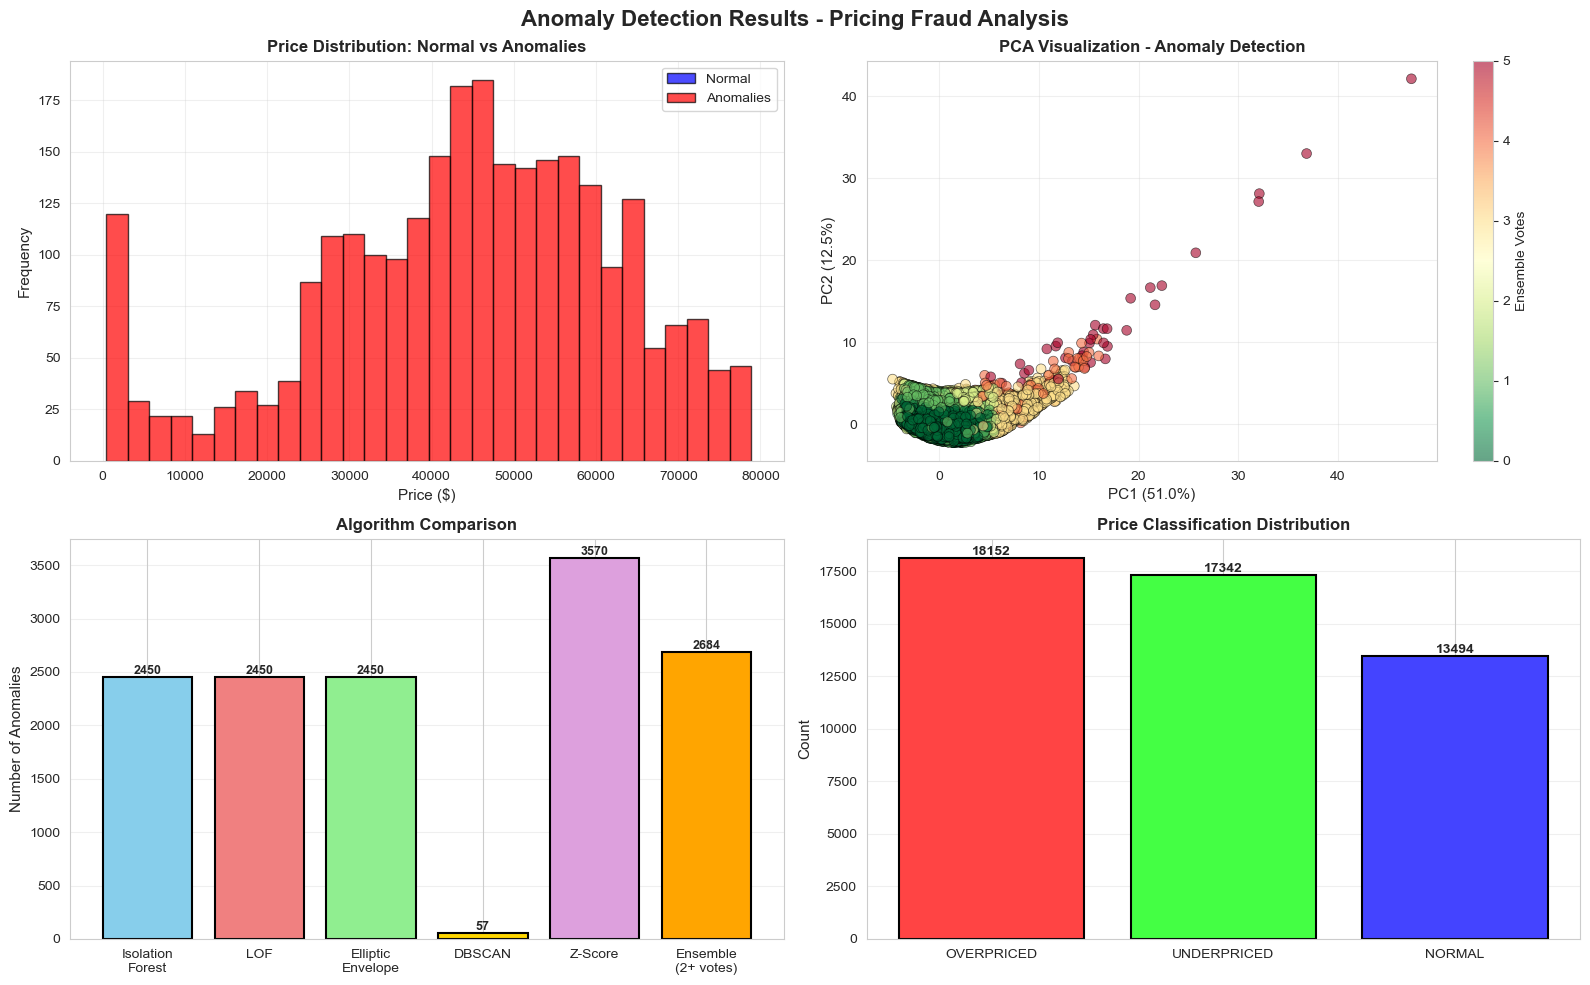

✓ Main visualization created


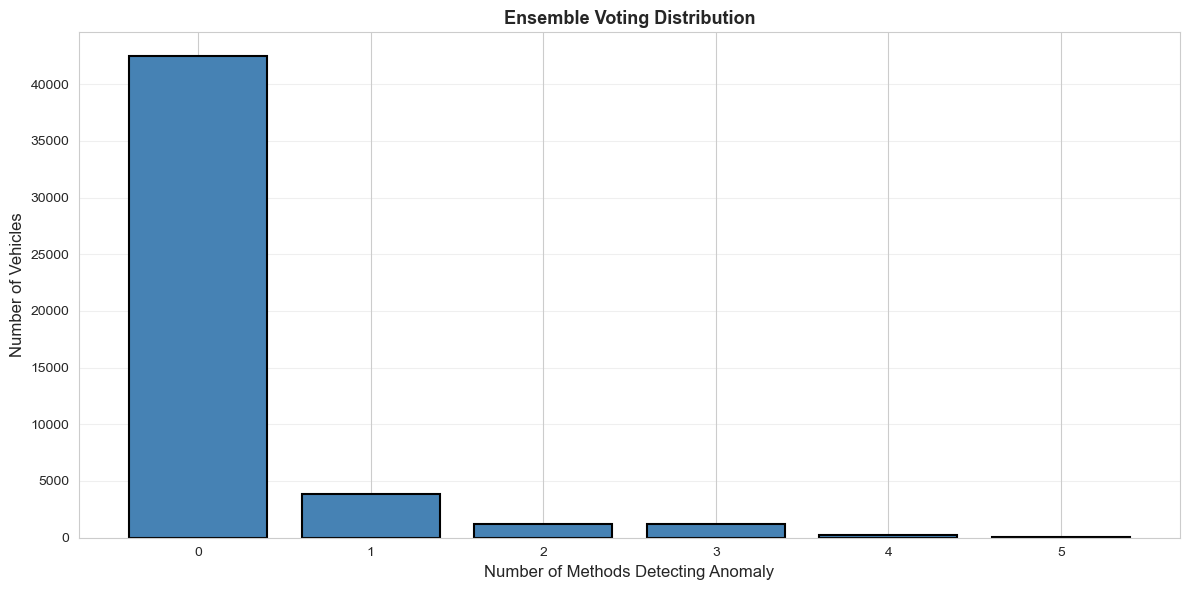

✓ Ensemble voting visualization created


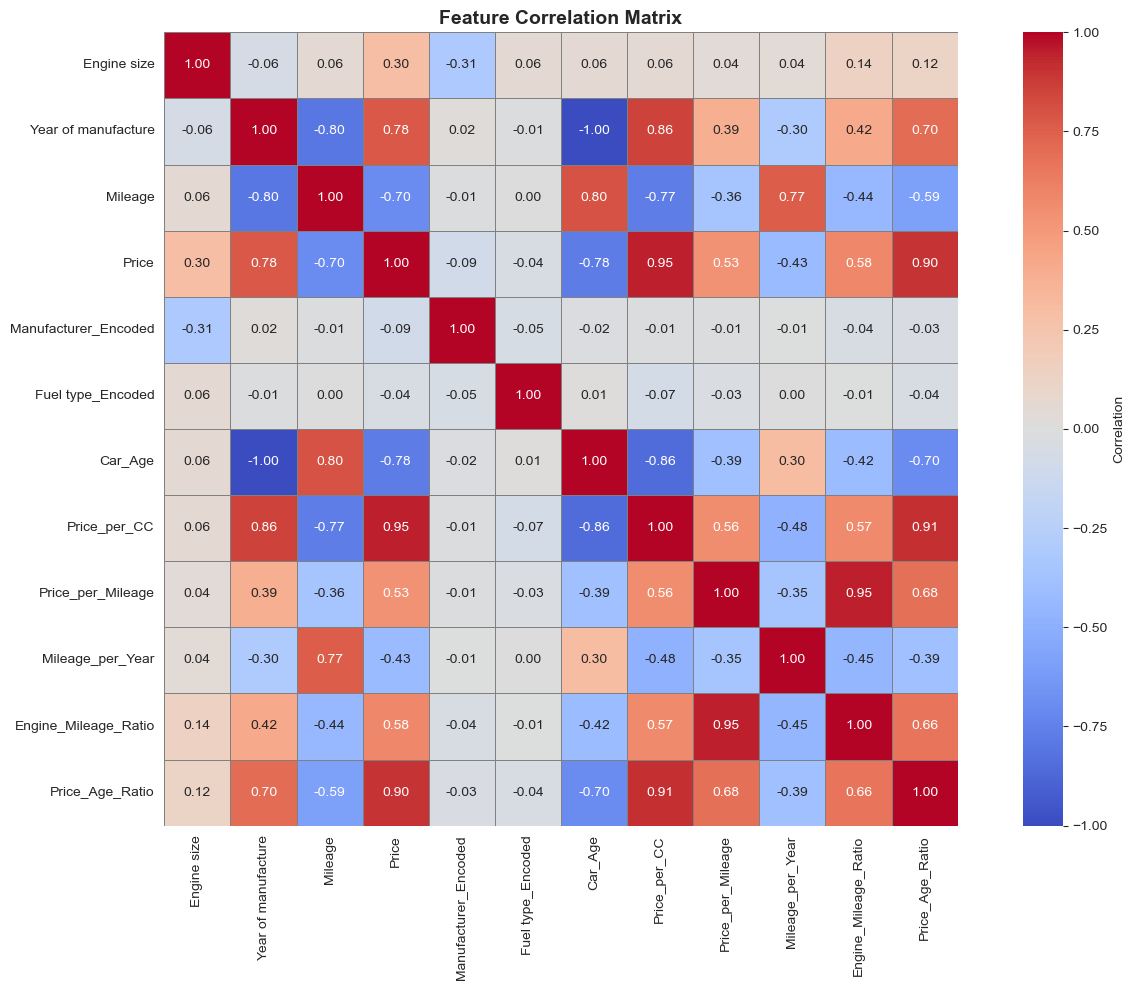

✓ Correlation heatmap created


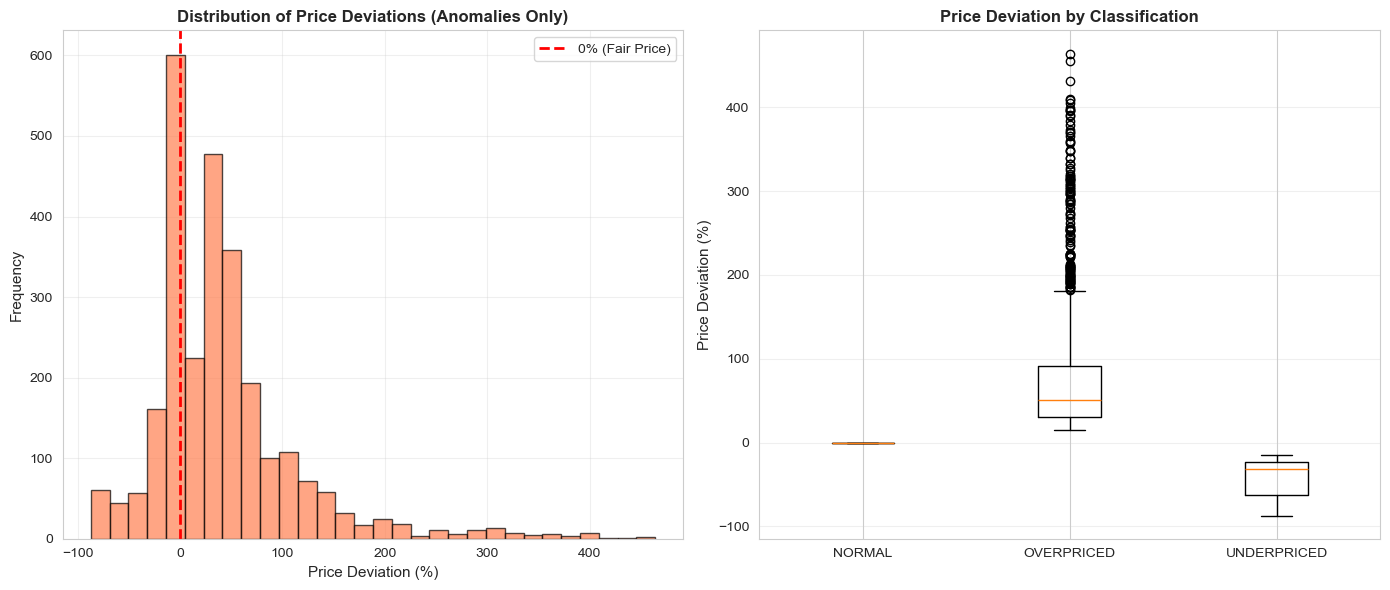

✓ Price deviation analysis created


In [ ]:
print("\n[STEP 9] CREATING COMPREHENSIVE VISUALIZATIONS")
print("-" * 90)

fig1, axes1 = plt.subplots(2, 2, figsize=(16, 10))
fig1.suptitle('Anomaly Detection Results - Pricing Fraud Analysis', fontsize=16, fontweight='bold')

ax1 = axes1[0, 0]
normal_prices = anomaly_results[anomaly_results['Ensemble_Prediction_Medium'] == 1]['Original_Price']
anomaly_prices = anomaly_results[anomaly_results['Ensemble_Prediction_Medium'] == -1]['Original_Price']

ax1.hist(normal_prices, bins=50, alpha=0.7, label='Normal', color='blue', edgecolor='black')
ax1.hist(anomaly_prices, bins=30, alpha=0.7, label='Anomalies', color='red', edgecolor='black')
ax1.set_xlabel('Price ($)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Price Distribution: Normal vs Anomalies', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2 = axes1[0, 1]
scatter = ax2.scatter(anomaly_results['PCA1'], anomaly_results['PCA2'],
                     c=anomaly_results['Ensemble_Votes'], cmap='RdYlGn_r', 
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax2.set_title('PCA Visualization - Anomaly Detection', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Ensemble Votes', fontsize=10)
ax2.grid(True, alpha=0.3)

ax3 = axes1[1, 0]
detection_summary = pd.DataFrame({
    'Algorithm': ['Isolation\nForest', 'LOF', 'Elliptic\nEnvelope', 'DBSCAN', 'Z-Score', 'Ensemble\n(2+ votes)'],
    'Anomalies': [iso_anomalies, lof_anomalies, ee_anomalies, dbscan_anomalies, 
                  z_score_anomalies, ensemble_anomalies_medium]
})
bars = ax3.bar(detection_summary['Algorithm'], detection_summary['Anomalies'],
               color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange'],
               edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Number of Anomalies', fontsize=11)
ax3.set_title('Algorithm Comparison', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax4 = axes1[1, 1]
classification_counts = anomaly_results['Price_Classification'].value_counts()
colors_map = {'OVERPRICED': '#FF4444', 'UNDERPRICED': '#44FF44', 'NORMAL': '#4444FF'}
colors = [colors_map.get(x, 'gray') for x in classification_counts.index]
bars4 = ax4.bar(classification_counts.index, classification_counts.values, 
                color=colors, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Count', fontsize=11)
ax4.set_title('Price Classification Distribution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Main visualization created")

fig2, ax = plt.subplots(figsize=(12, 6))
vote_dist = anomaly_results['Ensemble_Votes'].value_counts().sort_index()
ax.bar(vote_dist.index, vote_dist.values, color='steelblue', edgecolor='black', linewidth=1.5)
ax.set_xlabel('Number of Methods Detecting Anomaly', fontsize=12)
ax.set_ylabel('Number of Vehicles', fontsize=12)
ax.set_title('Ensemble Voting Distribution', fontsize=13, fontweight='bold')
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("✓ Ensemble voting visualization created")

fig3, ax = plt.subplots(figsize=(14, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=ax, fmt='.2f', cbar_kws={'label': 'Correlation'},
            linewidths=0.5, linecolor='gray')
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Correlation heatmap created")

fig4, axes4 = plt.subplots(1, 2, figsize=(14, 6))

ax4_1 = axes4[0]
deviation_data = anomaly_results[anomaly_results['Ensemble_Prediction_Medium'] == -1]['Price_Deviation_Percent']
ax4_1.hist(deviation_data, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax4_1.set_xlabel('Price Deviation (%)', fontsize=11)
ax4_1.set_ylabel('Frequency', fontsize=11)
ax4_1.set_title('Distribution of Price Deviations (Anomalies Only)', fontsize=12, fontweight='bold')
ax4_1.axvline(0, color='red', linestyle='--', linewidth=2, label='0% (Fair Price)')
ax4_1.legend()
ax4_1.grid(True, alpha=0.3)

ax4_2 = axes4[1]
classification_groups = anomaly_results[anomaly_results['Ensemble_Prediction_Medium'] == -1].groupby('Price_Classification')['Price_Deviation_Percent']
box_data = [group.values for name, group in classification_groups]
box_labels = [name for name, group in classification_groups]
ax4_2.boxplot(box_data, labels=box_labels)
ax4_2.set_ylabel('Price Deviation (%)', fontsize=11)
ax4_2.set_title('Price Deviation by Classification', fontsize=12, fontweight='bold')
ax4_2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Price deviation analysis created")

In [ ]:
print("\n[STEP 11] STATISTICAL SUMMARY TABLES")
print("-" * 90)

summary_by_anomaly = pd.DataFrame({
    'Metric': ['Count', 'Avg Price', 'Avg Mileage', 'Avg Car Age', 'Avg Engine Size'],
    'Normal': [
        (anomaly_results['Ensemble_Prediction_Medium'] == 1).sum(),
        df_processed[anomaly_results['Ensemble_Prediction_Medium'] == 1]['Price'].mean(),
        df_processed[anomaly_results['Ensemble_Prediction_Medium'] == 1]['Mileage'].mean(),
        df_processed[anomaly_results['Ensemble_Prediction_Medium'] == 1]['Car_Age'].mean(),
        df_processed[anomaly_results['Ensemble_Prediction_Medium'] == 1]['Engine size'].mean(),
    ],
    'Anomalies': [
        (anomaly_results['Ensemble_Prediction_Medium'] == -1).sum(),
        df_processed[anomaly_results['Ensemble_Prediction_Medium'] == -1]['Price'].mean(),
        df_processed[anomaly_results['Ensemble_Prediction_Medium'] == -1]['Mileage'].mean(),
        df_processed[anomaly_results['Ensemble_Prediction_Medium'] == -1]['Car_Age'].mean(),
        df_processed[anomaly_results['Ensemble_Prediction_Medium'] == -1]['Engine size'].mean(),
    ]
})

print("\nComparison: Normal vs Anomalous Vehicles")
print(summary_by_anomaly.to_string(index=False))

print("\n\nAlgorithm Agreement Analysis:")
agreement_matrix = pd.crosstab(
    anomaly_results['Ensemble_Votes'],
    anomaly_results['Price_Classification'],
    margins=True
)
print(agreement_matrix)


[STEP 11] STATISTICAL SUMMARY TABLES
------------------------------------------------------------------------------------------

Comparison: Normal vs Anomalous Vehicles
         Metric  Normal    Anomalies
          Count     0.0  2684.000000
      Avg Price     NaN 44090.252235
    Avg Mileage     NaN 40473.229508
    Avg Car Age     NaN     9.787258
Avg Engine Size     NaN     2.439083


Algorithm Agreement Analysis:
Price_Classification  NORMAL  OVERPRICED  UNDERPRICED    All
Ensemble_Votes                                              
0                      12004       14456        15997  42457
1                        889        1935         1023   3847
2                        209         767          229   1205
3                        330         822           80   1232
4                         54         144           13    211
5                          8          28            0     36
All                    13494       18152        17342  48988


In [ ]:
print("\n[STEP 12] FEATURE IMPORTANCE ANALYSIS")
print("-" * 90)

feature_anomaly_corr = pd.DataFrame({
    'Feature': feature_columns,
    'Corr_with_IF_Score': [X_scaled_df[col].corr(anomaly_results['IF_Anomaly_Score']) for col in feature_columns],
    'Corr_with_LOF_Score': [X_scaled_df[col].corr(anomaly_results['LOF_Score']) for col in feature_columns],
    'Avg_Abs_Correlation': [
        (abs(X_scaled_df[col].corr(anomaly_results['IF_Anomaly_Score'])) + 
         abs(X_scaled_df[col].corr(anomaly_results['LOF_Score']))) / 2
        for col in feature_columns
    ]
}).sort_values('Avg_Abs_Correlation', ascending=False)

print("\nTop Features Contributing to Anomaly Detection:")
print(feature_anomaly_corr.head(8).to_string(index=False))

print("\n" + "=" * 90)
print("COMPLETE PROJECT EXECUTION FINISHED!")
print("=" * 90)
print(f"\nTotal Processing Time: Check console for execution time")
print(f"All output files saved successfully!")
print(f"\nKey Metrics Summary:")
print(f"  • Total Vehicles Analyzed: {len(df_processed):,}")
print(f"  • High-Confidence Anomalies: {ensemble_anomalies_strict}")
print(f"  • Medium-Confidence Anomalies: {ensemble_anomalies_medium}")
print(f"  • Overpriced Vehicles Detected: {(anomaly_results['Price_Classification'] == 'OVERPRICED').sum()}")
print(f"  • Underpriced Vehicles Detected: {(anomaly_results['Price_Classification'] == 'UNDERPRICED').sum()}")
print(f"\nRecommended Action: Review 'high_confidence_anomalies.csv' immediately!")


[STEP 12] FEATURE IMPORTANCE ANALYSIS
------------------------------------------------------------------------------------------

Top Features Contributing to Anomaly Detection:
             Feature  Corr_with_IF_Score  Corr_with_LOF_Score  Avg_Abs_Correlation
         Engine size            0.007267             0.002552             0.004909
Manufacturer_Encoded            0.006389            -0.002181             0.004285
    Mileage_per_Year           -0.001670            -0.005987             0.003829
Engine_Mileage_Ratio            0.001725             0.004880             0.003303
   Price_per_Mileage            0.001452             0.004215             0.002833
             Car_Age            0.003193            -0.001799             0.002496
 Year of manufacture           -0.003193             0.001799             0.002496
   Fuel type_Encoded           -0.004198             0.000719             0.002459

COMPLETE PROJECT EXECUTION FINISHED!

Total Processing Time: Check consol